# 1. Data Exploration

This notebook explores the CAMELYON16 dataset and demonstrates:
- Loading WSI files with OpenSlide
- Creating tissue masks from thumbnails
- Visualizing tumor annotations

## Why Patch-Based Processing?

Whole Slide Images (WSIs) are **massive** - typically 100,000 x 100,000 pixels.
Loading one into memory would require ~30GB RAM!

Instead, we:
1. Work with low-resolution thumbnails for planning (~512x512)
2. Extract small patches (224x224) for training
3. Use coordinate mapping between resolutions

In [10]:
# REMOVE THIS CODE ONCE WE@RE HAPPY ALL IS WORKING WELL
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Navigate to project folder
%cd /content/drive/MyDrive/new_work/Projects/Camelyon16

# Verify were're in the right place
!ls
# Should show: README.md  config.py  notebooks/  requirements.txt  scripts/  src/

# Install dependencies
!apt-get install -y openslide-tools
!pip install openslide-python boto3 shapely scikit-image

# Now imports will work
from src.data import list_s3_files, download_file_from_s3, cleanup_file
from src.data.tissue_mask import get_tissue_mask
print("Imports successful!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/new_work/Projects/Camelyon16
config.py  LICENSE  notebooks  __pycache__  README.md  requirements.txt  src
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-5build1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
Imports successful!


In [11]:
# Install dependencies
!apt-get install -y openslide-tools
!pip install openslide-python boto3 shapely scikit-image

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-5build1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [12]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import openslide

from src.data import list_s3_files, download_file_from_s3, cleanup_file
from src.data.tissue_mask import compute_foreground_mask, filter_valid_components
from src.data.tumor_polygons import load_tumor_polygons

## 1.1 List Available Slides

The CAMELYON16 dataset is publicly available on AWS S3.

In [13]:
S3_IMAGES = 's3://camelyon-dataset/CAMELYON16/images/'
S3_ANNOTATIONS = 's3://camelyon-dataset/CAMELYON16/annotations/'

all_slides = list_s3_files(S3_IMAGES, '.tif')
normal_slides = [f for f in all_slides if 'normal' in f.lower()]
tumor_slides = [f for f in all_slides if 'tumor' in f.lower()]

print(f"Normal slides: {len(normal_slides)}")
print(f"Tumor slides: {len(tumor_slides)}")
print(f"\nExamples: {normal_slides[:3]}")

Normal slides: 159
Tumor slides: 111

Examples: ['normal_001.tif', 'normal_002.tif', 'normal_003.tif']


## 1.2 Load and Explore a WSI

WSIs are stored in a pyramidal format with multiple resolution levels.

In [9]:
# Download a sample slide
slide_filename = 'tumor_001.tif'
slide_path = download_file_from_s3(S3_IMAGES, slide_filename, '/tmp')

# Open with OpenSlide
slide = openslide.OpenSlide(slide_path)

print(f"Full resolution: {slide.dimensions}")
print(f"Number of levels: {slide.level_count}")
print(f"\nLevel details:")
for level in range(slide.level_count):
    dims = slide.level_dimensions[level]
    downsample = slide.level_downsamples[level]
    print(f"  Level {level}: {dims}, {downsample:.1f}x downsampled")

Full resolution: (97792, 221184)
Number of levels: 10

Level details:
  Level 0: (97792, 221184), 1.0x downsampled
  Level 1: (48896, 110592), 2.0x downsampled
  Level 2: (24448, 55296), 4.0x downsampled
  Level 3: (12224, 27648), 8.0x downsampled
  Level 4: (6112, 13824), 16.0x downsampled
  Level 5: (3056, 6912), 32.0x downsampled
  Level 6: (1528, 3456), 64.0x downsampled
  Level 7: (764, 1728), 128.0x downsampled
  Level 8: (382, 864), 256.0x downsampled
  Level 9: (191, 432), 512.0x downsampled


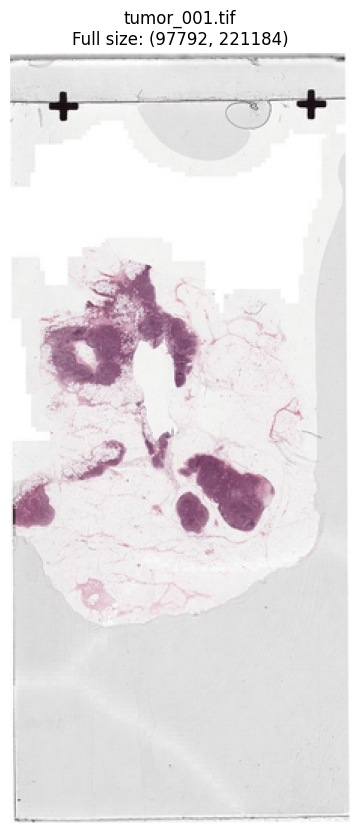

In [14]:
# Get a thumbnail for visualization
thumbnail = slide.get_thumbnail((512, 512))

plt.figure(figsize=(10, 10))
plt.imshow(thumbnail)
plt.title(f'{slide_filename}\nFull size: {slide.dimensions}')
plt.axis('off')
plt.show()

## 1.3 Tissue Mask Generation

We need to identify where the tissue is (vs. white background).

**Key insight**: Tissue is darker than the white glass background.
- Background: ~255 (white)
- Tissue: typically < 180 (darker)

We can detect tissue at thumbnail resolution (fast!) and map coordinates back to full resolution.

We use a two-step process: First step filters on brightness and does basic cleaning. Second step then filters out artefacts (on the basis of size and aspect ratio). We sometimes lose some tissue using this second, stringent filter!

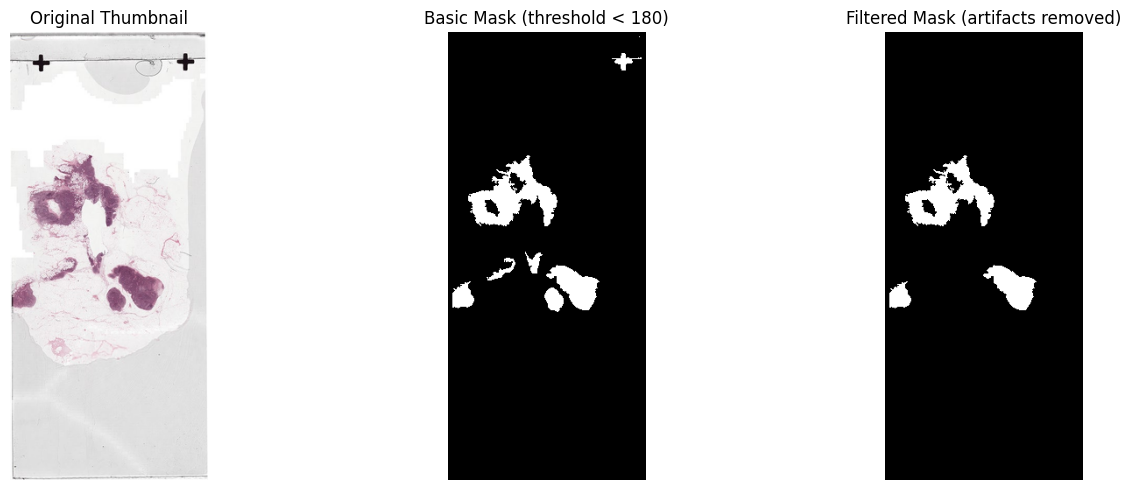

Tissue coverage: 5.0%


In [15]:
# Generate tissue mask
mask_basic = compute_foreground_mask(slide)
mask_filtered = filter_valid_components(mask_basic)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(thumbnail)
axes[0].set_title('Original Thumbnail')
axes[0].axis('off')

axes[1].imshow(mask_basic, cmap='gray')
axes[1].set_title('Basic Mask (threshold < 180)')
axes[1].axis('off')

axes[2].imshow(mask_filtered, cmap='gray')
axes[2].set_title('Filtered Mask (artifacts removed)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Tissue coverage: {mask_filtered.mean():.1%}")

## 1.4 Tumor Annotations

Tumor slides come with XML annotation files containing polygon coordinates.

In [16]:
# Download annotations
xml_filename = 'tumor_001.xml'
xml_path = download_file_from_s3(S3_ANNOTATIONS, xml_filename, '/tmp')

# Load tumor polygons
polygons = load_tumor_polygons(xml_path)
print(f"Found {len(polygons)} tumor regions")

for i, poly in enumerate(polygons[:3]):
    print(f"  Region {i+1}: area = {poly.area:,.0f} pixels²")

Found 2 tumor regions
  Region 1: area = 1,970,178 pixels²
  Region 2: area = 9,407,404 pixels²


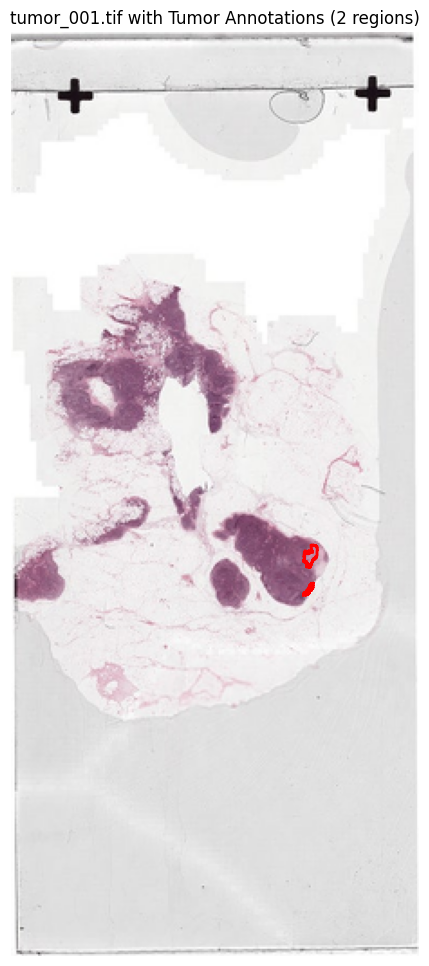

In [17]:
# Visualize tumor regions on thumbnail
import matplotlib.patches as mpatches

# Calculate scaling from slide to thumbnail
slide_w, slide_h = slide.dimensions
thumb_w, thumb_h = thumbnail.size
scale_x = thumb_w / slide_w
scale_y = thumb_h / slide_h

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(thumbnail)

# Draw each polygon
for polygon in polygons:
    # Scale coordinates to thumbnail space
    coords = list(polygon.exterior.coords)
    scaled = [(x * scale_x, y * scale_y) for x, y in coords]

    patch = mpatches.Polygon(scaled, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(patch)

ax.set_title(f'{slide_filename} with Tumor Annotations ({len(polygons)} regions)')
ax.axis('off')
plt.show()

## 1.5 Cleanup

Always clean up downloaded files to save disk space.

In [18]:
slide.close()
cleanup_file(slide_path)
cleanup_file(xml_path)
print("Cleaned up temporary files")

Cleaned up temporary files


## Summary

Key takeaways:
1. **WSIs are huge** - we can't load them fully into memory
2. **Thumbnails are fast** - use them for tissue detection and planning
3. **Coordinate mapping** - work in thumbnail space, extract patches at full resolution
4. **Tumor annotations** - XML files contain polygon coordinates for tumor regions

Next: [02_patch_extraction.ipynb](02_patch_extraction.ipynb) - Extract patches for training